# Pipeline

In [2]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.compose import ColumnTransformer
# standard scaler
from sklearn.preprocessing import StandardScaler
# train_test_split
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
# linear regression
from sklearn.linear_model import LinearRegression
import joblib
import pickle
import optuna
import cloudpickle

In [3]:
test_data = pd.read_csv('../../data/raw/TEST_FINAL.csv', parse_dates=['Date'])
train_data = pd.read_csv('../../data/raw/train.csv', parse_dates=['Date'])
clusters = pd.read_csv('../../data/processed/store_cluster.csv')

In [4]:
study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="LightGBM", load_if_exists=True)

[I 2025-01-07 02:44:51,596] Using an existing study with name 'LightGBM' instead of creating a new one.


In [5]:
train_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52
...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41


In [6]:
test_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No
...,...,...,...,...,...,...,...,...
22260,T1210601,186,S2,L5,R2,2019-07-31,0,No
22261,T1210602,11,S4,L2,R1,2019-07-31,0,No
22262,T1210603,185,S1,L1,R3,2019-07-31,0,Yes
22263,T1210604,69,S1,L1,R4,2019-07-31,0,No


In [7]:
forecast_start_date = '2019-06-01'
last_30_days = train_data[train_data['Date'] >= pd.to_datetime(forecast_start_date) - pd.Timedelta('30 days')]
last_30_days = last_30_days[last_30_days["Store_id"]==1]


In [8]:

forecast_data = test_data[test_data["Store_id"]==1].head(1)
forecast_data[['Sales', 'Orders']] = np.nan, np.nan

In [9]:
forecast_data =pd.concat([last_30_days, forecast_data], ignore_index=True)
forecast_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales
0,T1177523,1,S1,L3,R1,2019-05-02,0,No,53.0,34710.00
1,T1178031,1,S1,L3,R1,2019-05-03,0,Yes,80.0,52362.00
2,T1178361,1,S1,L3,R1,2019-05-04,0,Yes,94.0,66564.00
3,T1178557,1,S1,L3,R1,2019-05-05,0,Yes,116.0,79806.00
4,T1179091,1,S1,L3,R1,2019-05-06,0,Yes,88.0,64491.00
5,T1179526,1,S1,L3,R1,2019-05-07,0,Yes,92.0,66288.00
6,T1179591,1,S1,L3,R1,2019-05-08,0,No,35.0,22731.00
7,T1180017,1,S1,L3,R1,2019-05-09,1,No,34.0,22276.38
8,T1180513,1,S1,L3,R1,2019-05-10,0,No,59.0,37437.00
9,T1180756,1,S1,L3,R1,2019-05-11,0,No,86.0,53016.00


In [10]:
last_30_days[last_30_days["Store_id"]==1].shape

(30, 10)

In [11]:
last_30_days

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales
177522,T1177523,1,S1,L3,R1,2019-05-02,0,No,53,34710.00
178030,T1178031,1,S1,L3,R1,2019-05-03,0,Yes,80,52362.00
178360,T1178361,1,S1,L3,R1,2019-05-04,0,Yes,94,66564.00
178556,T1178557,1,S1,L3,R1,2019-05-05,0,Yes,116,79806.00
179090,T1179091,1,S1,L3,R1,2019-05-06,0,Yes,88,64491.00
179525,T1179526,1,S1,L3,R1,2019-05-07,0,Yes,92,66288.00
179590,T1179591,1,S1,L3,R1,2019-05-08,0,No,35,22731.00
180016,T1180017,1,S1,L3,R1,2019-05-09,1,No,34,22276.38
180512,T1180513,1,S1,L3,R1,2019-05-10,0,No,59,37437.00
180755,T1180756,1,S1,L3,R1,2019-05-11,0,No,86,53016.00


In [12]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropped_indices_ = None  # To store the indices of dropped rows
        self.included_indices_ = None  # To store the indices of included rows

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        result = result.drop(columns=['ID', 'Orders'], axis=1, errors='ignore')
        result = result.sort_values(by=['Store_id', 'Date'])
        result = result.merge(clusters, on='Store_id', how='left')
        result['Day'] = result['Date'].dt.day
        result["Day_of_Week"] = result["Date"].dt.dayofweek
        result["Month"] = result["Date"].dt.month
        result["Year"] = result["Date"].dt.year
        result["Quarter"] = result["Date"].dt.quarter
        result["Week"] = result["Date"].dt.isocalendar().week
        result["Week_of_Month"] = result["Date"].dt.day.apply(lambda x: (x-1) // 7 + 1)
        result["Is_Weekend"] = result["Day_of_Week"].apply(lambda x: 1 if x >= 5 else 0)
        result["Discount"] = result["Discount"].apply(lambda x: 1 if x == 'Yes' else 0)

        # Create lag features
        result['Sales_Lag_1'] = result.groupby('Store_id')['Sales'].shift(1)
        result['Sales_Lag_7'] = result.groupby('Store_id')['Sales'].shift(7)
        result['Sales_Lag_12'] = result.groupby('Store_id')['Sales'].shift(12)
        result['Sales_Lag_30'] = result.groupby('Store_id')['Sales'].shift(30)

        # Create moving average features
        result['Sales_Mean_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).mean()
        result['Sales_Mean_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).mean()
        result['Sales_Mean_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).mean()

        # Create moving standard deviation features
        result['Sales_Std_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).std()
        result['Sales_Std_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).std()
        result['Sales_Std_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).std()

        # Create moving min and max features
        result['Sales_Min_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).min()
        result['Sales_Min_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).min()
        result['Sales_Min_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).min()

        result['Sales_Max_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).max()
        result['Sales_Max_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).max()
        result['Sales_Max_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).max()


        # Create expanding mean and standard deviation features
        result['Sales_Expanding_Mean'] = result.groupby('Store_id')['Sales'].shift(1).ewm(alpha=0.9, adjust=False).mean()
        # result['Sales_Expanding_Weighted_Mean'] = result.groupby('Store_id')['Sales'].expanding().apply(lambda x: np.average(x, weights=np.arange(1, len(x)+1))).shift(1).reset_index(level=0, drop=True)
        result['Sales_Expanding_Std'] = result.groupby('Store_id')['Sales'].shift(1).ewm(alpha=0.9, adjust=False).std()
        result['Sales_Expanding_Sum'] = result.groupby('Store_id')['Sales'].expanding().sum().shift(1).reset_index(level=0, drop=True)


        # ohe = OneHotEncoder(categories='auto')
        # feature_array = ohe.fit_transform(result[['Store_Type', 'Location_Type', 'Region_Code','cluster']]).toarray()
        # result = pd.concat([result.reset_index(drop=True), pd.DataFrame(feature_array, columns=ohe.get_feature_names_out()).reset_index(drop=True)], axis=1).drop(['Store_Type', 'Location_Type', 'Region_Code', 'cluster'], axis=1)
        result = result.drop(columns=["Date","Store_id"], axis=1)
        # encode cyclical features
        result['Day_sin'] = np.sin(2 * np.pi * result['Day']/31)
        result['Day_cos'] = np.cos(2 * np.pi * result['Day']/31)

        result['Day_of_Week_sin'] = np.sin(2 * np.pi * result['Day_of_Week']/6)
        result['Day_of_Week_cos'] = np.cos(2 * np.pi * result['Day_of_Week']/6)

        result['Month_sin'] = np.sin(2 * np.pi * result['Month']/12)
        result['Month_cos'] = np.cos(2 * np.pi * result['Month']/12)

        result['Quarter_sin'] = np.sin(2 * np.pi * result['Quarter']/4)
        result['Quarter_cos'] = np.cos(2 * np.pi * result['Quarter']/4)

        result['Week_sin'] = np.sin(2 * np.pi * result['Week']/52)
        result['Week_cos'] = np.cos(2 * np.pi * result['Week']/52)

        result['Week_of_Month_sin'] = np.sin(2 * np.pi * result['Week_of_Month']/5)
        result['Week_of_Month_cos'] = np.cos(2 * np.pi * result['Week_of_Month']/5)

        # add fourier features for 7 days, 12 days, 30 days
        # result['Day_7_sin'] = np.sin(2 * np.pi * result['Day']/7)
        # result['Day_7_cos'] = np.cos(2 * np.pi * result['Day']/7)

        # result['Day_12_sin'] = np.sin(2 * np.pi * result['Day']/12)
        # result['Day_12_cos'] = np.cos(2 * np.pi * result['Day']/12)

        # drop original cyclical features
        result = result.drop(columns=['Day', 'Day_of_Week', 'Month', 'Quarter', 'Week', 'Week_of_Month', 'Year', 'Sales'], axis=1)
        
        self.dropped_indices_ = result.index[result.isnull().any(axis=1)].tolist()
        result = result.dropna()
        self.included_indices_ = result.index.tolist()

        return result
    
class TargetAligner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Align target variable with included indices
        if y is not None:
            return X, y.iloc[X.index]
        return X


In [13]:
df = train_data.copy()

In [14]:
pipeline = Pipeline([
    ('feature_generator', FeatureGenerator()),
    ('categorical_encoder', ColumnTransformer([
        ('onehot', OneHotEncoder(), ['Store_Type', 'Location_Type', 'Region_Code', 'cluster'])
    ], remainder='passthrough', verbose_feature_names_out=False)),
    ('scaler', StandardScaler())
])
transformed_df = pipeline.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns=pipeline[1].get_feature_names_out())
lgbm = LGBMRegressor(**study.best_params, n_jobs=-1, random_state=42, num_threads=-1, boosting_type="goss", data_sample_strategy="goss")
lgbm.fit(transformed_df, df.iloc[pipeline[0].included_indices_]["Sales"])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 177390, number of used features: 51
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 42788.136136


LGBMRegressor(boosting_type='goss', data_sample_strategy='goss',
              learning_rate=0.05550627930432799, max_depth=11, n_estimators=170,
              n_jobs=-1, num_leaves=78, num_threads=-1, random_state=42,
              subsample=0.8824247534381798)

In [15]:
transformed_forecast_data = pipeline.transform(forecast_data)
lgbm.predict(transformed_forecast_data)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


array([45315.58623479])

In [16]:
transformed_forecast_data.shape

(1, 51)

In [22]:
last_training_date = pd.to_datetime("2019-05-31")
first_forecast_date = pd.to_datetime("2019-06-01")

def build_future_dataframe(Store_id=1, days=30, train_data=train_data, test_data=test_data, date=first_forecast_date):
    train_data = train_data.copy()
    test_data = test_data.copy()
    last_30_days = train_data[train_data['Date'] >= pd.to_datetime(date) - pd.Timedelta(f'{days} days')]
    last_30_days = last_30_days[last_30_days["Store_id"]==Store_id]

    forecast_data = test_data[test_data["Store_id"]==Store_id]
    forecast_data = forecast_data[forecast_data["Date"] == date]
    assert forecast_data["Date"].iloc[0] == date
    forecast_data[['Sales', 'Orders']] = np.nan, np.nan
    print(forecast_data.to_dict(orient='records'))

    forecast_data =pd.concat([last_30_days, forecast_data], ignore_index=True)

    assert forecast_data.shape[0] == last_30_days.shape[0] + 1

    transformed_forecast_data = pipeline.transform(forecast_data)
    forecast = lgbm.predict(transformed_forecast_data)

    forecast_data.iloc[-1, forecast_data.columns.get_loc("Sales")] = forecast
    forecast_data.iloc[-1, forecast_data.columns.get_loc("Orders")] = 0

    return forecast_data


In [ ]:
import pandas as pd

first_forecast_date = pd.to_datetime("2019-06-01")
updated_forecast = build_future_dataframe(Store_id=1, days=30, train_data=train_data, test_data=test_data, date=first_forecast_date)

for i in range(1, 31):
    next_date = first_forecast_date + pd.Timedelta(days=i)
    updated_forecast = build_future_dataframe(Store_id=1, days=30, train_data=updated_forecast, test_data=test_data, date=next_date)

[{'ID': 'T1188651', 'Store_id': 1, 'Store_Type': 'S1', 'Location_Type': 'L3', 'Region_Code': 'R1', 'Date': Timestamp('2019-06-01 00:00:00'), 'Holiday': 0, 'Discount': 'No', 'Sales': nan, 'Orders': nan}]
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[{'ID': 'T1189050', 'Store_id': 1, 'Store_Type': 'S1', 'Location_Type': 'L3', 'Region_Code': 'R1', 'Date': Timestamp('2019-06-02 00:00:00'), 'Holiday': 0, 'Discount': 'No', 'Sales': nan, 'Orders': nan}]
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[{'ID': 'T1189337', 'Store_id': 1, 'Store_Type': 'S1', 'Location_Type': 'L3', 'Region_Code': 'R1', 'Date': Timestamp('2019-06-03 00:00:00'), 'Holiday': 0, 'Discount': '

In [24]:
updated_forecast

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales
0,T1188651,1,S1,L3,R1,2019-06-01,0,No,0.0,47624.974160
1,T1189050,1,S1,L3,R1,2019-06-02,0,No,0.0,43578.772630
2,T1189337,1,S1,L3,R1,2019-06-03,0,No,0.0,41315.378920
3,T1189632,1,S1,L3,R1,2019-06-04,0,No,0.0,43446.070734
4,T1190137,1,S1,L3,R1,2019-06-05,1,No,0.0,46999.238709
5,T1190485,1,S1,L3,R1,2019-06-06,0,No,0.0,43369.346239
6,T1190858,1,S1,L3,R1,2019-06-07,0,No,0.0,45784.443265
7,T1190913,1,S1,L3,R1,2019-06-08,0,Yes,0.0,43487.339290
8,T1191316,1,S1,L3,R1,2019-06-09,0,Yes,0.0,41520.342450
9,T1191747,1,S1,L3,R1,2019-06-10,0,Yes,0.0,37690.292228


<Axes: xlabel='Date'>

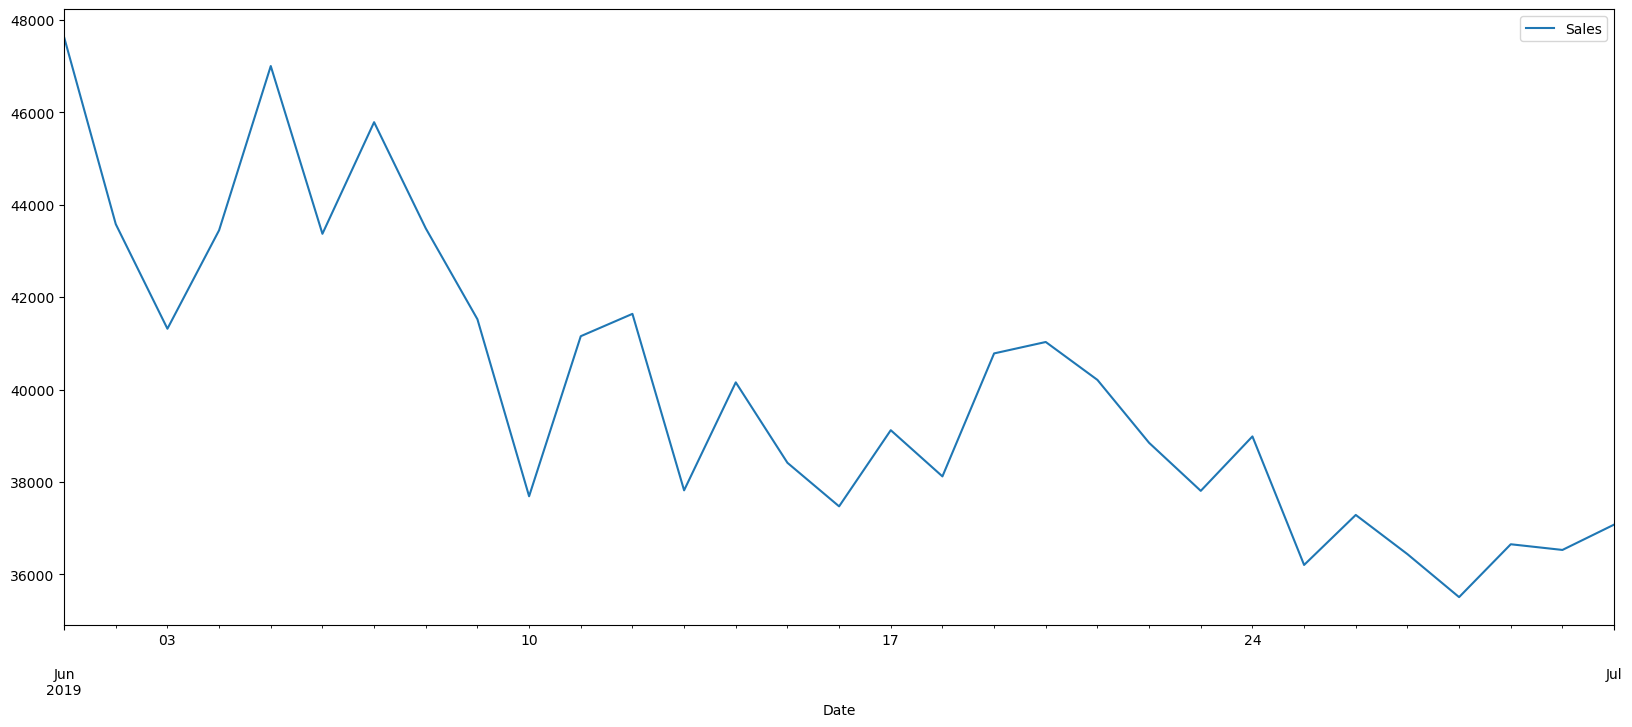

In [25]:

updated_forecast.plot(x='Date', y='Sales', kind='line', figsize=(20, 8))

In [17]:
# save pipeline
# joblib.dump(pipeline, '../../deploy/models/pipeline.joblib')
# # save model
# joblib.dump(lgbm, '../../deploy/models/model_lgbm.joblib')

# cloudpickle
with open('../../deploy/models/pipeline.pkl', 'wb') as f:
    cloudpickle.dump(pipeline, f)

with open('../../deploy/models/model_lgbm.pkl', 'wb') as f:
    cloudpickle.dump(lgbm, f)

In [29]:
train_data[train_data['Date'] >= pd.to_datetime(first_forecast_date) - pd.Timedelta('30 days')].to_parquet('../../deploy/data/train_data.parquet')

In [33]:
test_data[test_data['Date'] <= pd.to_datetime(first_forecast_date) + pd.Timedelta('30 days')].to_parquet('../../deploy/data/test_data.parquet')